In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
plt.rcParams['figure.figsize']=[10,5]
plt.rcParams['figure.dpi']=150
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load dataset
file_path = "/content/exchange_rate.csv"
df = pd.read_csv(file_path)
df['Date']=pd.to_datetime(df.date,format="%d-%m-%Y %H:%M")
df.head()

,date,Ex_rate,Date
0,01-01-1990 00:00,0.7855,1990-01-01
1,02-01-1990 00:00,0.7818,1990-01-02
2,03-01-1990 00:00,0.7867,1990-01-03
3,04-01-1990 00:00,0.7860,1990-01-04
4,05-01-1990 00:00,0.7849,1990-01-05


In [ ]:
df.columns

Index(['date', 'Ex_rate', 'Date'], dtype='object')

In [ ]:
#Extract date and exchange rate columns
# Assuming the first two columns are 'date' and the exchange rate:
df.columns = ['date', 'Ex_rate','Date']  # Adjust column names as needed
df = df[['Date', 'Ex_rate']]  # Select only the desired columns
df.columns = ["Date", "ExchangeRate"]  # Rename to your preferred names
df["t"] = np.arange(1, len(df) + 1)  # Time index for trend models
df["t_squared"] = df["t"] ** 2  # Quadratic term

# Convert 'ExchangeRate' column to numeric, handling errors
df["ExchangeRate"] = pd.to_numeric(df["ExchangeRate"], errors='coerce')
# errors='coerce' will replace non-numeric values with NaN

# Now apply log transformation, ignoring NaN values
df["log_ExchangeRate"] = np.log(df["ExchangeRate"].dropna())  # Log transformation, ignoring NaN values

In [ ]:
df.head()

,Date,ExchangeRate,t,t_squared,log_ExchangeRate
0,1990-01-01,0.7855,1,1,-0.241435
1,1990-01-02,0.7818,2,4,-0.246156
2,1990-01-03,0.7867,3,9,-0.239908
3,1990-01-04,0.7860,4,16,-0.240798
4,1990-01-05,0.7849,5,25,-0.242199


<Axes: >

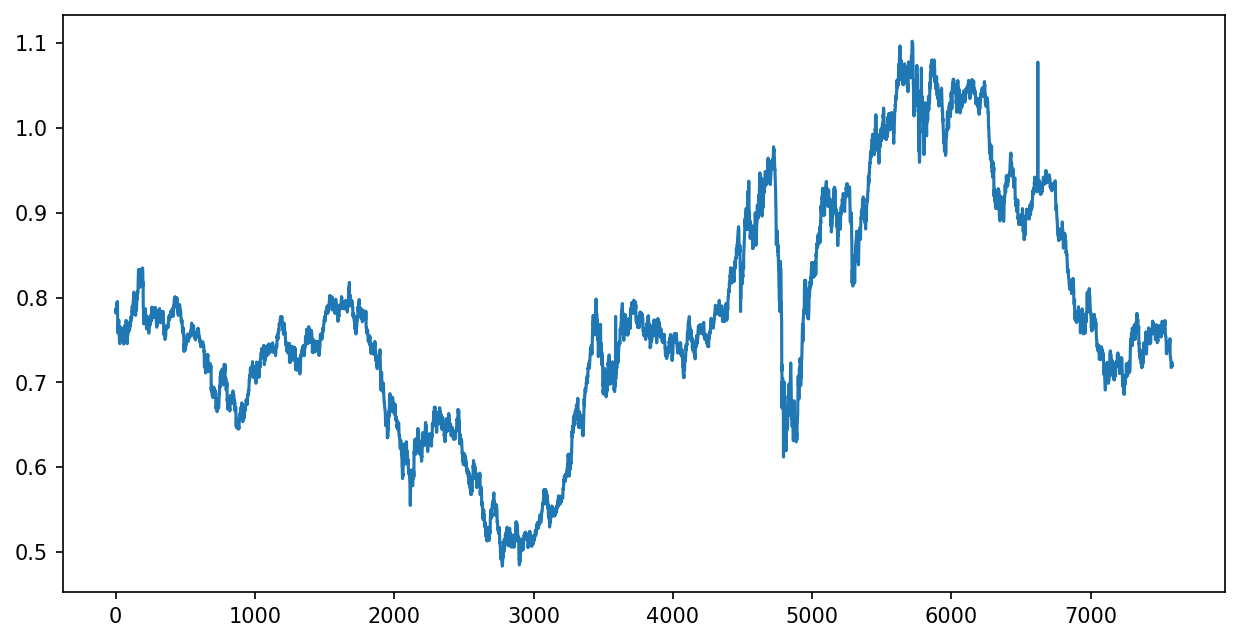

In [ ]:
df.ExchangeRate.plot()

In [ ]:
df.dtypes

,0
Date,datetime64[ns]
ExchangeRate,float64
t,int64
t_squared,int64
log_ExchangeRate,float64


In [ ]:
df.isna().sum()

,0
Date,0
ExchangeRate,0
t,0
t_squared,0
log_ExchangeRate,0


In [ ]:
# Train-test split (80% train, 20% test)
train_size = int(0.8 * len(df))
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [ ]:
# Function to calculate RMSE
def calculate_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [ ]:
# ---- LINEAR MODEL ----
linear_model = sm.OLS(train["ExchangeRate"], sm.add_constant(train["t"])).fit()
linear_pred = linear_model.predict(sm.add_constant(test["t"]))
linear_rmse = calculate_rmse(test["ExchangeRate"], linear_pred)

In [ ]:
# ---- EXPONENTIAL MODEL ----
exp_model = sm.OLS(train["log_ExchangeRate"], sm.add_constant(train["t"])).fit()
exp_pred = np.exp(exp_model.predict(sm.add_constant(test["t"])))
exp_rmse = calculate_rmse(test["ExchangeRate"], exp_pred)

In [ ]:
# ---- QUADRATIC MODEL ----
quad_model = sm.OLS(train["ExchangeRate"], sm.add_constant(train[["t", "t_squared"]])).fit()
quad_pred = quad_model.predict(sm.add_constant(test[["t", "t_squared"]]))
quad_rmse = calculate_rmse(test["ExchangeRate"], quad_pred)

In [ ]:
# ---- ADDITIVE SEASONALITY MODEL ----
train["month"] = train["Date"].dt.month.astype("category")
test["month"] = test["Date"].dt.month.astype("category")
# Convert dummy variables to numeric using astype(int)
seasonal_model = sm.OLS(train["ExchangeRate"], sm.add_constant(pd.get_dummies(train["month"], drop_first=True).astype(int))).fit()
seasonal_pred = seasonal_model.predict(sm.add_constant(pd.get_dummies(test["month"], drop_first=True).astype(int)))
seasonal_rmse = calculate_rmse(test["ExchangeRate"], seasonal_pred)

In [ ]:
# ---- ADDITIVE SEASONALITY WITH QUADRATIC TREND ----
train["month"] = train["Date"].dt.month.astype("category")
test["month"] = test["Date"].dt.month.astype("category")

# Explicitly convert dummy variables to numeric (float64)
X_train = pd.concat([train[["t", "t_squared"]], pd.get_dummies(train["month"], drop_first=True)], axis=1).astype(np.float64)
X_test = pd.concat([test[["t", "t_squared"]], pd.get_dummies(test["month"], drop_first=True)], axis=1).astype(np.float64)

seasonal_quad_model = sm.OLS(train["ExchangeRate"], sm.add_constant(X_train)).fit()
seasonal_quad_pred = seasonal_quad_model.predict(sm.add_constant(X_test))
seasonal_quad_rmse = calculate_rmse(test["ExchangeRate"], seasonal_quad_pred)

In [ ]:

# ---- MULTIPLICATIVE SEASONALITY MODEL ----
# Ensure 'month' column is of numeric type and handle missing values
train["month"] = train["Date"].dt.month.astype(int)  # Convert to numeric
test["month"] = test["Date"].dt.month.astype(int)   # Convert to numeric

# One-hot encode 'month' and handle NaN values if present
train_month_dummies = pd.get_dummies(train["month"], drop_first=True, dummy_na=False).astype(float)  # dummy_na=False to avoid NaN dummies
test_month_dummies = pd.get_dummies(test["month"], drop_first=True, dummy_na=False).astype(float)    # dummy_na=False to avoid NaN dummies

# Fit the model with numeric data and handle NaNs if any in log_ExchangeRate
seasonal_mult_model = sm.OLS(
    train["log_ExchangeRate"].fillna(0),  # Fill NaNs in log_ExchangeRate with 0 or another appropriate value
    sm.add_constant(train_month_dummies)
).fit()
# Predict and calculate RMSE for the multiplicative seasonality model
seasonal_mult_pred = np.exp(seasonal_mult_model.predict(sm.add_constant(test_month_dummies)))
seasonal_mult_rmse = calculate_rmse(test["ExchangeRate"], seasonal_mult_pred)


In [ ]:
# ---- RESULTS ----
rmse_results = pd.DataFrame({
    "Model": [
        "Linear Model",
        "Exponential Model",
        "Quadratic Model",
        "Additive Seasonality",
        "Additive Seasonality + Quadratic",
        "Multiplicative Seasonality",
    ],
    "RMSE": [
        linear_rmse,
        exp_rmse,
        quad_rmse,
        seasonal_rmse,
        seasonal_quad_rmse,
        seasonal_mult_rmse,
    ],
})

print("\nRMSE Results:")
print(rmse_results.sort_values(by="RMSE"))


RMSE Results:
                              Model      RMSE
1                 Exponential Model  0.137337
0                      Linear Model  0.142629
3              Additive Seasonality  0.143198
5        Multiplicative Seasonality  0.151224
2                   Quadratic Model  0.507075
4  Additive Seasonality + Quadratic  0.507813


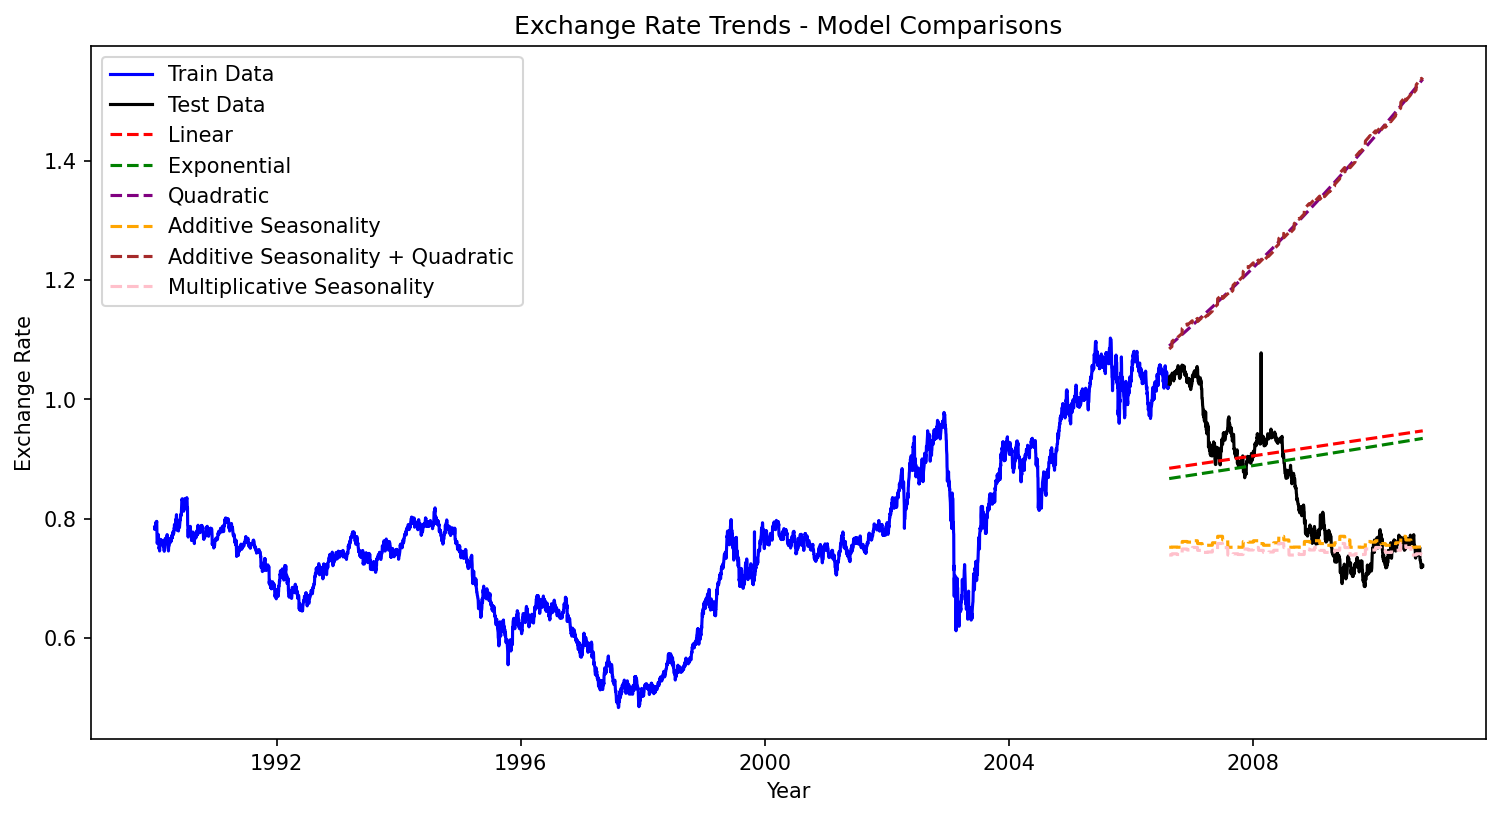

In [ ]:
# ---- PLOT MODELS ----
plt.figure(figsize=(12, 6))
plt.plot(train["Date"], train["ExchangeRate"], label="Train Data", color="blue")
plt.plot(test["Date"], test["ExchangeRate"], label="Test Data", color="black")
plt.plot(test["Date"], linear_pred, label="Linear", linestyle="dashed", color="red")
plt.plot(test["Date"], exp_pred, label="Exponential", linestyle="dashed", color="green")
plt.plot(test["Date"], quad_pred, label="Quadratic", linestyle="dashed", color="purple")
plt.plot(test["Date"], seasonal_pred, label="Additive Seasonality", linestyle="dashed", color="orange")
plt.plot(test["Date"], seasonal_quad_pred, label="Additive Seasonality + Quadratic", linestyle="dashed", color="brown")
plt.plot(test["Date"], seasonal_mult_pred, label="Multiplicative Seasonality", linestyle="dashed", color="pink")
plt.xlabel("Year")
plt.ylabel("Exchange Rate")
plt.title("Exchange Rate Trends - Model Comparisons")
plt.legend()
plt.show()


In [ ]:
# Import necessary libraries
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Check for stationarity using ADF Test
adfuller(df["ExchangeRate"])[1]
#gives the p value
#if p<0.05 data is stationary
   #p>0.05 data is non stationary*/

0.4492327353597477

In [ ]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.6 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima
order = auto_arima(df['ExchangeRate'])
order

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# If not stationary, perform first-order differencing
df_diff = df.diff().dropna()
print("ADF Test for Differenced Series:")
# Check for stationarity using ADF Test
adfuller(df_diff["ExchangeRate"])[1]
#gives the p value
#if p<0.05 data is stationary
   #p>0.05 data is non stationary*/

ADF Test for Differenced Series:


0.0

In [ ]:
order = auto_arima(df_diff['ExchangeRate'])
order

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

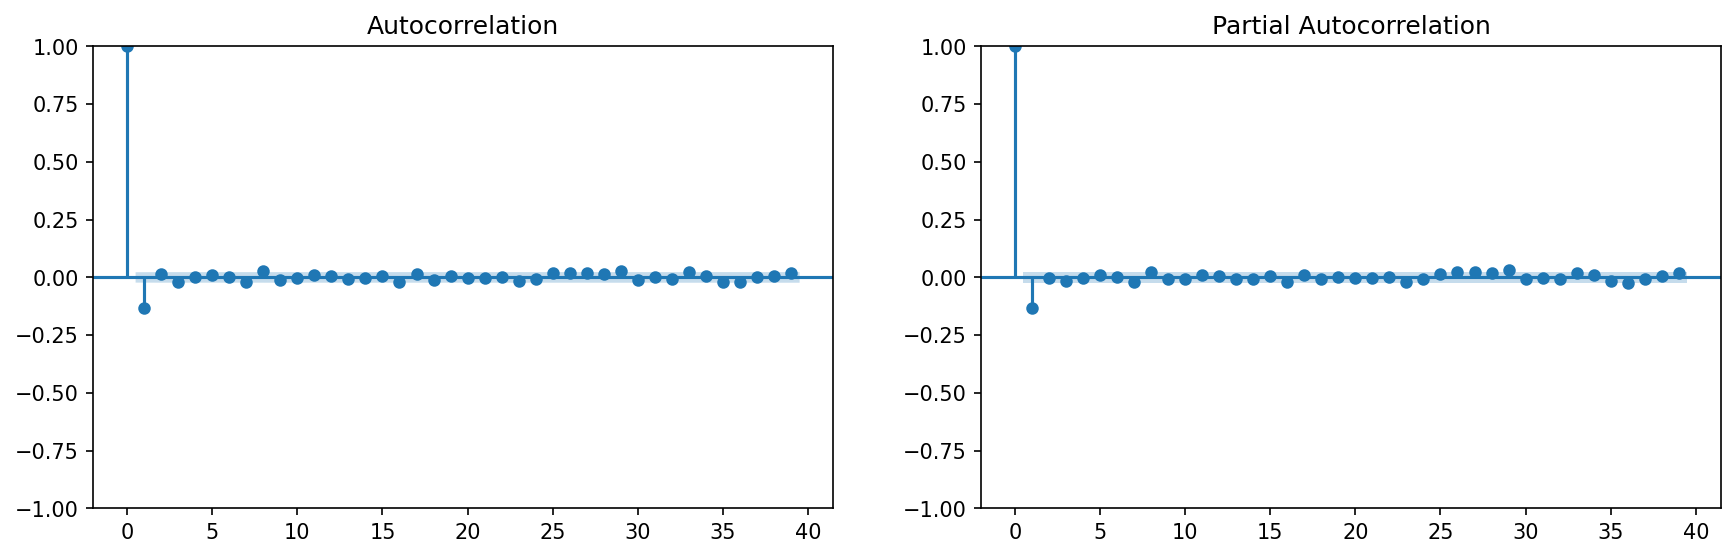

In [ ]:
# Plot ACF and PACF for ARIMA parameter selection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Select only the 'ExchangeRate' column, which is numeric
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df_diff['ExchangeRate'], ax=axes[0])  # Use df_diff['ExchangeRate']
plot_pacf(df_diff['ExchangeRate'], ax=axes[1]) # Use df_diff['ExchangeRate']
plt.show()

In [ ]:
# Fit ARIMA Model
p, d, q = 1, 0, 0  # Adjust based on ACF/PACF plots
arima_model = ARIMA(train['ExchangeRate'], order=(p, d, q)).fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:           ExchangeRate   No. Observations:                 6070
Model:                 ARIMA(1, 0, 0)   Log Likelihood               22705.546
Date:                Tue, 04 Feb 2025   AIC                         -45405.093
Time:                        05:52:16   BIC                         -45384.960
Sample:                             0   HQIC                        -45398.105
                               - 6070                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7587      0.130      5.832      0.000       0.504       1.014
ar.L1          0.9994      0.000   2118.364      0.000       0.998       1.000
sigma2      3.296e-05   1.78e-07    184.857      0.0

In [ ]:
y_predarima=arima_model.predict(start=test.index[0],end=test.index[-1])
y_predarima

,predicted_mean
6070,1.023399
6071,1.023246
6072,1.023093
6073,1.022941
6074,1.022788
...,...
7583,0.869168
7584,0.869105
7585,0.869041
7586,0.868977


In [ ]:
print(mean_squared_error(test['ExchangeRate'],y_predarima))

0.012166238106815157


In [ ]:
# Import necessary libraries
from IPython import get_ipython
from IPython.display import display
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Function to evaluate models using RMSE
def evaluate_model(test_data, predictions):
    mae = mean_absolute_error(test_data, predictions)
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    return mae, rmse

# ---- Model Selection ----
models = {
    "Simple Exponential Smoothing": ExponentialSmoothing(train['ExchangeRate'], trend=None, seasonal=None),
    "Holt's Linear Trend Model": ExponentialSmoothing(train['ExchangeRate'], trend="add", seasonal=None),
    "Holt-Winters Additive": ExponentialSmoothing(train['ExchangeRate'], trend="add", seasonal="add", seasonal_periods=12),
    "Holt-Winters Multiplicative": ExponentialSmoothing(train['ExchangeRate'], trend="add", seasonal="mul", seasonal_periods=12),
}


best_model = None
best_rmse = float("inf")

# ---- Parameter Optimization & Model Fitting ----
results = []
for name, model in models.items():
    fitted_model = model.fit()
    predictions = fitted_model.forecast(steps=len(test))

    # Compute error metrics
    mae, rmse = evaluate_model(test["ExchangeRate"], predictions)
    results.append({"Model": name, "MAE": mae, "RMSE": rmse})

    # Store best model
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = fitted_model
        best_model_name = name

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("\nModel Selection Results:")
print(results_df)



Model Selection Results:
                          Model       MAE      RMSE
0  Simple Exponential Smoothing  0.177638  0.205356
1     Holt's Linear Trend Model  0.190273  0.220084
3   Holt-Winters Multiplicative  0.205542  0.237874
2         Holt-Winters Additive  0.206755  0.239289


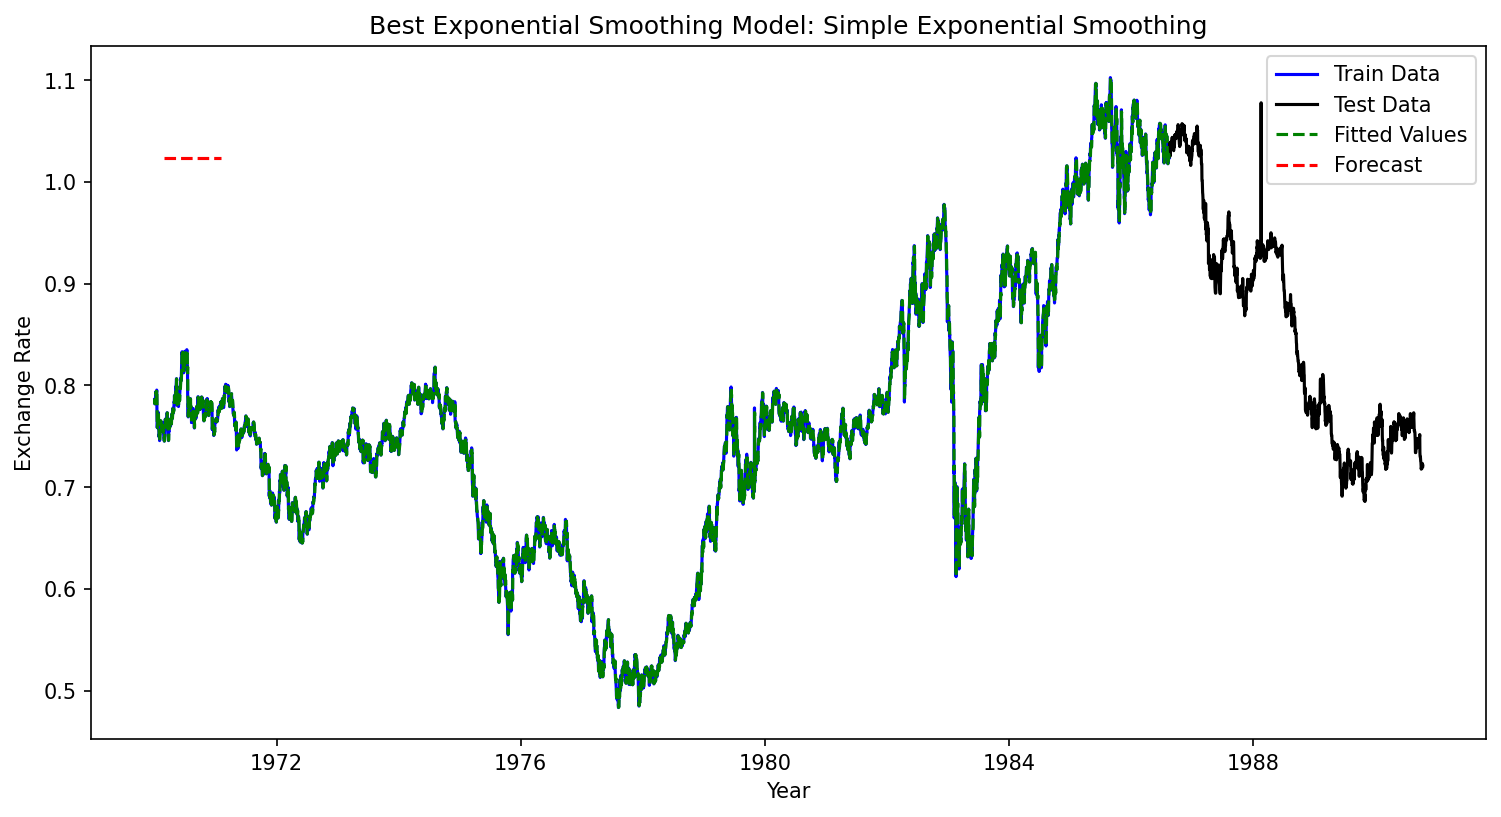

In [ ]:
# ---- Forecast with Best Model ----
forecast_steps = 12  # Predict for 12 months
forecast = best_model.forecast(steps=forecast_steps)

# ---- Plot Forecast vs. Actual ----
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["ExchangeRate"], label="Train Data", color="blue")
plt.plot(test.index, test["ExchangeRate"], label="Test Data", color="black")
plt.plot(train.index, best_model.fittedvalues, label="Fitted Values", linestyle="dashed", color="green")
plt.plot(pd.date_range(test.index[-1], periods=forecast_steps + 1, freq="M")[1:], forecast, label="Forecast", linestyle="dashed", color="red")
plt.xlabel("Year")
plt.ylabel("Exchange Rate")
plt.title(f"Best Exponential Smoothing Model: {best_model_name}")
plt.legend()
plt.show()

In [ ]:
# Calculate error metrics for ARIMA
arima_mae = mean_absolute_error(test['ExchangeRate'], y_predarima)
arima_rmse = np.sqrt(mean_squared_error(test['ExchangeRate'], y_predarima))

# Calculate error metrics for Exponential Smoothing (using the best model)
holt_predictions = best_model.forecast(steps=len(test))  # Use the best model for predictions
holt_mae = mean_absolute_error(test['ExchangeRate'], holt_predictions)
holt_rmse = np.sqrt(mean_squared_error(test['ExchangeRate'], holt_predictions))

# Print evaluation results
print("\nModel Evaluation Metrics:")
print(f"ARIMA: MAE = {arima_mae:.4f}, RMSE = {arima_rmse:.4f}")
print(f"Exponential Smoothing: MAE = {holt_mae:.4f}, RMSE = {holt_rmse:.4f}")


# Summarize Model Performance
best_model = "ARIMA" if arima_rmse < holt_rmse else "Exponential Smoothing"

print("\nModel Comparison:")
if arima_rmse < holt_rmse:
    print("The ARIMA model performed better based on RMSE, indicating a better fit to the actual data.")
    print("Advantages of ARIMA: Captures trend and autocorrelations well.")
    print("Limitations: May require complex parameter tuning.")
else:
    print("The Exponential Smoothing model performed better based on RMSE, indicating a better fit to the actual data.")
    print("Advantages of Exponential Smoothing: Simple to implement, effective for stable patterns.")
    print("Limitations: May not perform well with sudden fluctuations.")

print("\nConclusion:")
print(f"The best model for forecasting exchange rates in this dataset is: **{best_model}**.")



Model Evaluation Metrics:
ARIMA: MAE = 0.0929, RMSE = 0.1103
Exponential Smoothing: MAE = 0.1776, RMSE = 0.2054

Model Comparison:
The ARIMA model performed better based on RMSE, indicating a better fit to the actual data.
Advantages of ARIMA: Captures trend and autocorrelations well.
Limitations: May require complex parameter tuning.

Conclusion:
The best model for forecasting exchange rates in this dataset is: **ARIMA**.
